# Chain

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='One of the best places to see orcas in the United States is in the Pacific Northwest, specifically the San Juan Islands in Washington State. The San Juan Islands are renowned for their resident orca pods, known as the Southern Resident Killer Whales. These waters provide an ideal environment for orcas, offering plenty of food, primarily Chinook salmon, and sheltered channels.\n\nThe best time to see orcas is typically from late spring to early fall, with the peak season being from May to September. During this time, various whale-watching tours operate from locations like Friday Harbor on San Juan Island, providing opportunities to see not only orcas but also other marine wildlife such as humpback whales, gray whales, sea lions, and porpoises.\n\nAnother good spot for orca watching is along the coast of Washington State and up into the waters around the Olympic Peninsula. Additional opportunities can be found in the Strait of Juan de Fuca and the Puget Sound area.\n\

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 228,
  'prompt_tokens': 67,
  'total_tokens': 295,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_f64f290af2',
 'id': 'chatcmpl-CQUH9RvOespQKlYC8UcguJ7lduFw5',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

llm_with_tools = llm.bind_tools([multiply,add])

In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_IACyanRgXwgr86iHyfRk5epj',
  'type': 'tool_call'}]

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [11]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [12]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [13]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b9954f8c-f854-4717-bfac-e6de23449acc'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='b14ea72b-7579-4de0-993f-b98d824bfd40'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='5e404d55-089a-48ec-b6c9-86364dcfce1e')]

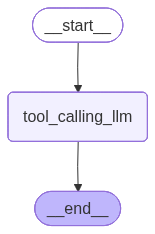

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VBd3r5MCPTbhQ2NVVGbb7alO)
 Call ID: call_VBd3r5MCPTbhQ2NVVGbb7alO
  Args:
    a: 2
    b: 3


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Add 9 and 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 9 and 10
================================== Ai Message ==================================
Tool Calls:
  add (call_4BdJ31u6TPyuSRvC8LHxmG17)
 Call ID: call_4BdJ31u6TPyuSRvC8LHxmG17
  Args:
    a: 9
    b: 10
